# Best Model Optimization

## Objective

The primary objectives of this project are:

1. Develop and evaluate a regression model to predict the sale price based on the features in the dataset.
2. Conduct a hyperparameter search to fine-tune the model.
3. Identify the best features to use in model training.

## Dataset

- **Dataset:** `house_prices_records.csv`
- Data cleaning and feature engineering instructions can be found in the respective notebooks.

## Outputs

The project will deliver the following outputs:

1. Test set with features and target.
2. Data cleaning and feature engineering pipeline.
3. Modeling pipeline.
4. Feate regression model pipeline.

## Optimization Process

The optimization process involvess.
- Selecting the best features.
- Evaluating the model's performance using appropriate regression metrics.o

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/test/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/test'

---

# Step 1: Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv")
  )

print(df.shape)
df.head(3)

(1460, 24)


1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0       856     854.0           3.0           No         706          GLQ   
1      1262       0.0           3.0           Gd         978          ALQ   
2       920     866.0           3.0           Mn         486          GLQ   

   BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  ...  LotFrontage  \
0        150            0.0         548          RFn  ...         65.0   
1        284            NaN         460          RFn  ...         80.0   
2        434            0.0         608          RFn  ...         68.0   

   MasVnrArea OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  WoodDeckSF  \
0       196.0          61            5            7          856         0.0   
1         0.0           0            8            6         1262         NaN   
2       162.0          42            5            7          920         NaN   

   YearBuilt  YearRemodAdd  SalePrice  
0       2003          2003     208500  
1       1976          1976     181500  
2       2001          2002     223500  

[3 rows x 24 columns]

---

# Step 2: ML Pipeline with all data

In [5]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.outliers   import Winsorizer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection, DropFeatures
from feature_engine import transformation as vt

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PiplineDataCleaningFeatureEngineering(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF','MasVnrArea'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing',fill_value='Unf', variables=['GarageFinish','BsmtFinType1'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF','GarageArea','TotalBsmtSF'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['LotArea'])),

        ("Winsorizer",Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['GrLivArea'])),
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling - Standardize features by removing the mean and scaling to unit variance.
        ("scaler", StandardScaler()),

        # Feature Selection - Meta-transformer for selecting features based on importance weights.
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base


/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## ML Pipeline for Modelling and Hyperparameter Optimisation

def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Custom Class for Hyperparameter Optimisation from code institute

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PiplineDataCleaningFeatureEngineering(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train and Test Set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(1168, 23) (1168,) (292, 23) (292,)


In [8]:
df.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0       856     854.0           3.0           No         706          GLQ   
1      1262       0.0           3.0           Gd         978          ALQ   
2       920     866.0           3.0           Mn         486          GLQ   

   BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  ...  LotFrontage  \
0        150            0.0         548          RFn  ...         65.0   
1        284            NaN         460          RFn  ...         80.0   
2        434            0.0         608          RFn  ...         68.0   

   MasVnrArea OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  WoodDeckSF  \
0       196.0          61            5            7          856         0.0   
1         0.0           0            8            6         1262         NaN   
2       162.0          42            5            7          920         NaN   

   YearBuilt  YearRemodAdd  SalePrice  
0       2003          2003     208500  
1       1976          1976     181500  
2       2001          2002     223500  

[3 rows x 24 columns]

## Grid Search CV - Sklearn

### Search a range of hyperparameters to look for the most suiteable parameters

the type of model has been decicded in the previous note book

In [9]:

models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor":{'model__n_estimators': [15,30, 50, 100, 150, 200, 400],
                                 'model__learning_rate':[0.01, 0.03, 0.05, 0.07, 0.1],
                                 'model__max_depth': [3, 8, 15],
                                 'model__min_samples_split': [2,50],
                                 'model__min_samples_leaf': [1,50],
                                 'model__max_leaf_nodes': [None,50],
    }
}

In [10]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 840 candidates, totalling 4200 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

estimator min_score mean_score max_score std_score  \
542  GradientBoostingRegressor  0.726169   0.795999  0.855075  0.042319   
514  GradientBoostingRegressor  0.726169   0.795887  0.855075   0.04226   
180  GradientBoostingRegressor  0.727797   0.795681  0.847915  0.039644   
208  GradientBoostingRegressor  0.727797   0.795561  0.847915  0.039581   
681  GradientBoostingRegressor  0.744721   0.794885  0.847001  0.035623   
..                         ...       ...        ...       ...       ...   
49   GradientBoostingRegressor  0.139754   0.157264  0.172403  0.013836   
21   GradientBoostingRegressor  0.139754   0.157264  0.172403  0.013836   
14   GradientBoostingRegressor  0.139754   0.157264  0.172403  0.013836   
0    GradientBoostingRegressor  0.133077    0.15455  0.169006  0.013751   
28   GradientBoostingRegressor  0.133077    0.15455  0.169006  0.013751   

    model__learning_rate model__max_depth model__max_leaf_nodes  \
542                 0.07                3                    50   
514                 0.07                3                  None   
180                 0.03                3                  None   
208                 0.03                3                    50   
681                  0.1                3                  None   
..                   ...              ...                   ...   
49                  0.01                3                    50   
21                  0.01                3                  None   
14                  0.01                3                  None   
0                   0.01                3                  None   
28                  0.01                3                    50   

    model__min_samples_leaf model__min_samples_split model__n_estimators  
542                       1                       50                 100  
514                       1                       50                 100  
180                       1                       50                 200  
208                       1                       50                 200  
681                       1                       50                  50  
..                      ...                      ...                 ...  
49                       50                       50                  15  
21                       50                       50                  15  
14                       50                        2                  15  
0                         1                        2                  15  
28                        1                        2                  15  

[840 rows x 11 columns]

In [12]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

In [13]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.07,
 'model__max_depth': 3,
 'model__max_leaf_nodes': 50,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 100}

In [14]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImputer(variables...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond

## Parameters optimization

In [15]:
best_parameters

{'model__learning_rate': 0.07,
 'model__max_depth': 3,
 'model__max_leaf_nodes': 50,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 100}

In [16]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [100],
        'model__max_depth': [3],
        'model__learning_rate': [0.07],
        'model__min_samples_split': [50],
        'model__min_samples_leaf': [1],
        'model__max_leaf_nodes': [50],
    }
}

In [17]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=20)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 20 folds for each of 1 candidates, totalling 20 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [18]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

estimator min_score mean_score max_score std_score  \
0  GradientBoostingRegressor  0.391687    0.77329  0.877836   0.11257   

  model__learning_rate model__max_depth model__max_leaf_nodes  \
0                 0.07                3                    50   

  model__min_samples_leaf model__min_samples_split model__n_estimators  
0                       1                       50                 100

In [19]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

In [20]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.07,
 'model__max_depth': 3,
 'model__max_leaf_nodes': 50,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 100}

In [21]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImputer(variables...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond

# Asses Feature importane

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']


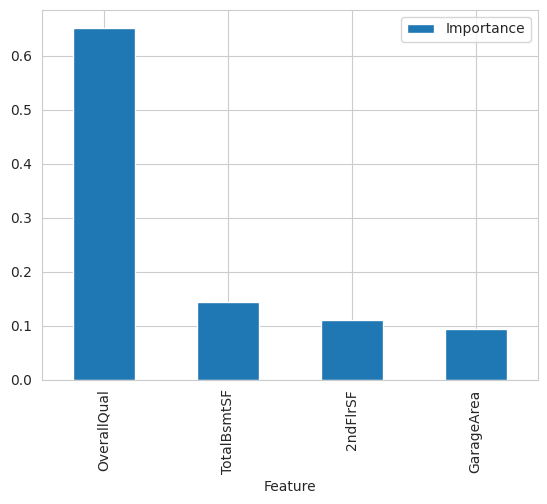

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 10 
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

# Evaluate on Train and Test Sets

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train,y_train,pipeline)
    print("* Test Set")
    regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))  
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))  
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Model Evaluation 

* Train Set
R2 Score: 0.886
Mean Absolute Error: 19237.255
Mean Squared Error: 699991691.703
Root Mean Squared Error: 26457.356


* Test Set
R2 Score: 0.835
Mean Absolute Error: 22311.227
Mean Squared Error: 1137426940.449
Root Mean Squared Error: 33725.761




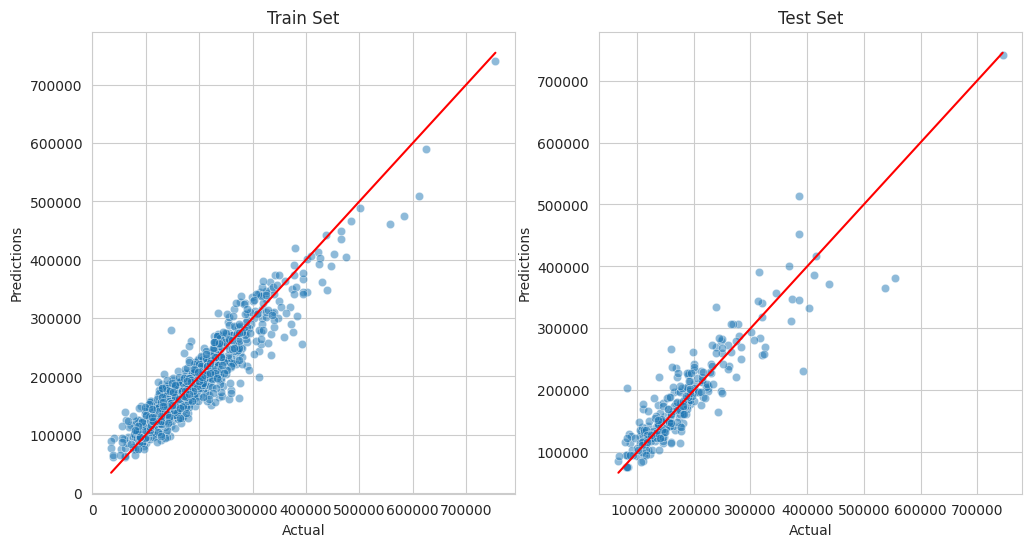

In [24]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_clf)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_clf)

---


## Rewriting the ML Pipeline

Rewriting the pipline is done to make the pipeline more efficient. Only to use the 4 most important features

In [25]:
def PiplineDataCleaningFeatureEngineering(model):
    pipeline_base = Pipeline([

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['GarageArea','TotalBsmtSF'])),

        # Feature Scaling
        ("scaler", StandardScaler()),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

In [26]:
#Optimal parameters see section Parameters Optimization
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [100],
        'model__max_depth': [3],
        'model__learning_rate': [0.07],
        'model__min_samples_split': [50],
        'model__min_samples_leaf': [1],
        'model__max_leaf_nodes': [50],
    }
}

In [31]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train_best.shape, y_train.shape, "\n* Test set:",  X_test_best.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 4) (1168,) 
* Test set: (292, 4) (292,)


2ndFlrSF  GarageArea  OverallQual  TotalBsmtSF
618       0.0         774            9         1822
870       0.0         308            5          894
92        0.0         432            5          876

In [50]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=50)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 50 folds for each of 1 candidates, totalling 50 fits


In [51]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

estimator min_score mean_score max_score std_score  \
0  GradientBoostingRegressor -0.594421   0.766919  0.948941  0.212119   

  model__learning_rate model__max_depth model__max_leaf_nodes  \
0                 0.07                3                    50   

  model__min_samples_leaf model__min_samples_split model__n_estimators  
0                       1                       50                 100

In [52]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

In [53]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['GarageArea',
                                                  'TotalBsmtSF'])),
                ('scaler', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.07,
                                           max_leaf_nodes=50,
                                           min_samples_split=50,
                                           random_state=0))])

In [ ]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_clf)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline_clf)

Model Evaluation 

* Train Set
R2 Score: 0.886
Mean Absolute Error: 19237.255
Mean Squared Error: 699991691.703
Root Mean Squared Error: 26457.356


* Test Set
R2 Score: 0.835
Mean Absolute Error: 22311.227
Mean Squared Error: 1137426940.449
Root Mean Squared Error: 33725.761




# Step 4: Push files to Repo

We will generate the following files
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [37]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_saleprice/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_saleprice/v1'


## Train Set

In [38]:
print(X_train.shape)
X_train.head()

(1168, 4)


2ndFlrSF  GarageArea  OverallQual  TotalBsmtSF
618       0.0         774            9         1822
870       0.0         308            5          894
92        0.0         432            5          876
817       0.0         857            8         1568
302       0.0         843            7         1541

In [39]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [40]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [41]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

* note that the variables are transformed already in X_test

In [42]:
print(X_test.shape)
X_test.head()

(292, 4)


2ndFlrSF  GarageArea  OverallQual  TotalBsmtSF
529       0.0         484            6         2035
491     620.0         240            6          806
459     224.0         352            5          709
279     866.0         505            7         1160
655       NaN         264            6          525

In [43]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [44]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [45]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

In [46]:
pipeline_clf

Pipeline(steps=[('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['GarageArea',
                                                  'TotalBsmtSF'])),
                ('scaler', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.07,
                                           max_leaf_nodes=50,
                                           min_samples_split=50,
                                           random_state=0))])

In [47]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/predict_saleprice/v1/clf_pipeline_model.pkl']

## Feature Importance plot

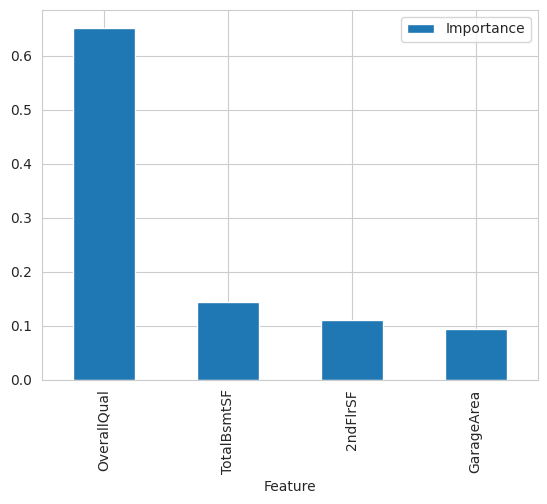

In [48]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

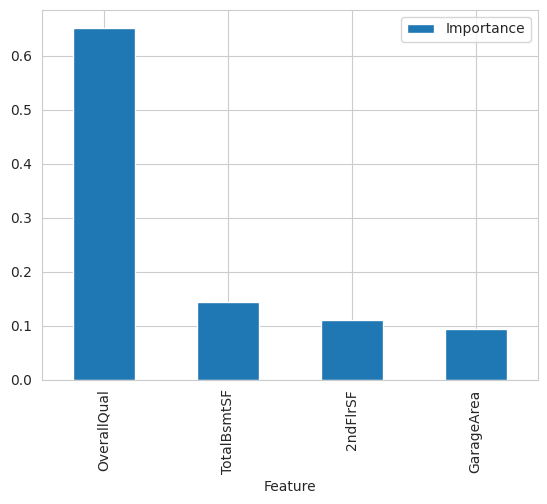

In [49]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

---